In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nolds
from nolitsa import lyapunov,dimension,delay,noise,data

In [2]:
%matplotlib inline
#We define a function useful to find local minimizers
def localmin(x):
    """Return all local minima from the given data set.
    Returns all local minima from the given data set.  Note that even
    "kinky" minima (which are probably not real minima) will be
    returned.
    Parameters
    ----------
    x : array
        1D scalar data set.
    Returns
    -------
    i : array
        Array containing location of all local minima.
    """
    return (np.diff(np.sign(np.diff(x))) > 0).nonzero()[0] + 1

In [3]:
#https://ourworldindata.org/coronavirus-source-data
data = pd.read_csv(r'C:\Users\javie\Covid19\datas\owid-covid-data-01-03.csv')
df =pd.DataFrame(data)

#Blegium
Blegiumdata=df.loc[df['location']=='Belgium']
Belgiumts=np.array(Blegiumdata.new_cases_per_million).astype(float)/10

#Norway
Norwaydata=df.loc[df['location']=='Norway']
Norwayts=np.array(Norwaydata.new_cases_per_million).astype(float)[1:]/10

#US
USdata=df.loc[df['location']=='United States']
USts=np.array(USdata.new_cases_per_million).astype(float)[1:]/10

#Chile
Chiledata=df.loc[df['location']=='Chile']
Chilets=np.array(Chiledata.new_cases_per_million).astype(float)/10

#Denmark
Denmarkdata=df.loc[df['location']=='Denmark']
Denmarkts=np.array(Denmarkdata.new_cases_per_million).astype(float)[25:]/10

#Canada
Canadadata=df.loc[df['location']=='Canada']
Canadats=np.array(Canadadata.new_cases_per_million).astype(float)/10

#Czec Republic
CzechRdata=df.loc[df['location']=='Czech Republic']
CzechRts=np.array(CzechRdata.new_cases_per_million).astype(float)/10

#New Zealand
NZdata=df.loc[df['location']=='New Zealand']
NZts=np.array(NZdata.new_cases_per_million).astype(float)/10

#Germany
Germanydata=df.loc[df['location']=='Germany']
Germanyts=np.array(Germanydata.new_cases_per_million).astype(float)[3:]/10

#Italy
Italydata=df.loc[df['location']=='Italy']
Italyts=np.array(Italydata.new_cases_per_million).astype(float)/10

#Japan
Japandata=df.loc[df['location']=='Japan']
Japants=np.array(Japandata.new_cases_per_million).astype(float)[1:]/10

#South Korea
SKdata=df.loc[df['location']=='South Korea']
SKts=np.array(SKdata.new_cases_per_million).astype(float)[2:]/10

#Australia
Australiadata=df.loc[df['location']=='Australia']
Australiats=np.array(Australiadata.new_cases_per_million).astype(float)/10

In [4]:
#We save the dates
Fechas=df['date'].astype(str).values.tolist()

In [9]:
Time_series=[Belgiumts,Norwayts,
             USts,Chilets,Denmarkts, 
             Germanyts, Italyts,
             Japants, SKts, Australiats, NZts]
Countries=['Belgium', 'Norway', 'United States', 'Chile', 'Denmark', 'Germany', 'Italy', 'Japan', 'South Korea',
       'Australia','New Zealand']

In [10]:
N=11
L=250
TS=[]
for serie in Time_series:
    TS.append(serie[:L])

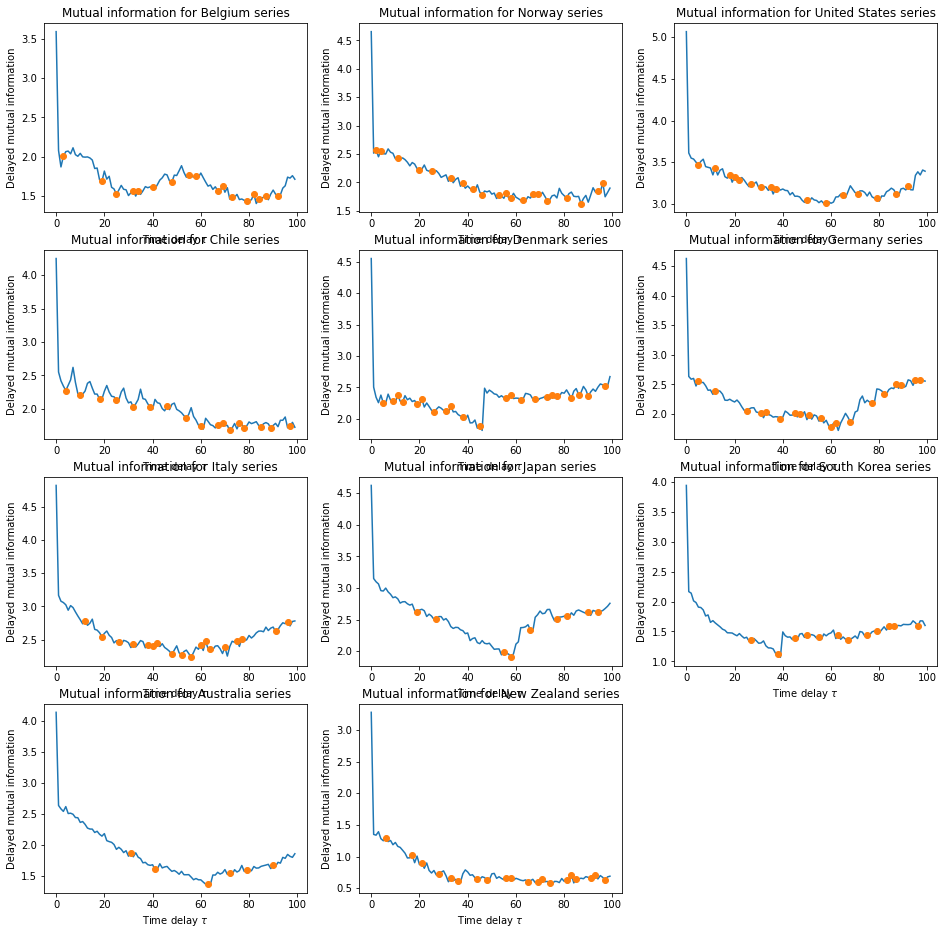

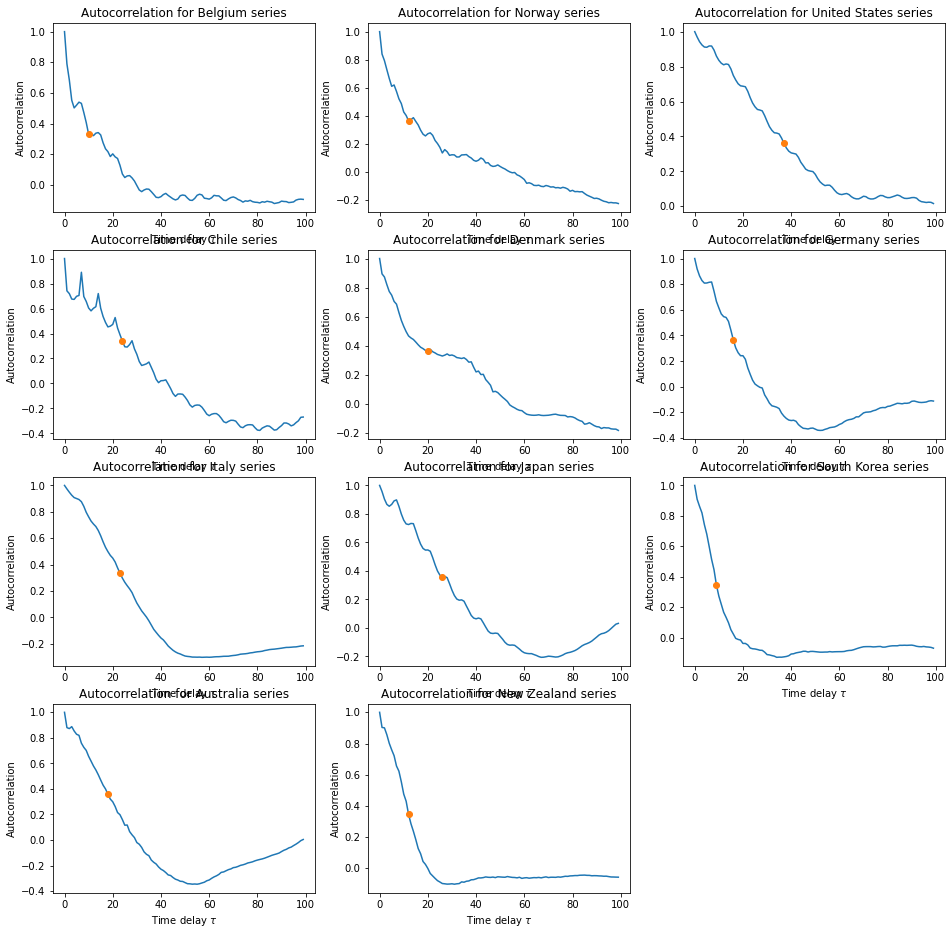

In [11]:
#Mutual information.
# Compute autocorrelation and delayed mutual information.
lag = np.arange(100)
i_delay=np.zeros(N)
r_delay=np.zeros(N)
plt.figure(1,figsize=(16,16))
Minimals=np.zeros(N)
for j in range(N):
    x=TS[j]
    i = delay.dmi(x, maxtau=100)
    i_delay = localmin(noise.sma(i, hwin=1)) + 1
    plt.subplot(4,3,j+1)
    plt.title(r'Mutual information for ' + str(Countries[j]) +' series')
    plt.ylabel(r'Delayed mutual information')
    plt.xlabel(r'Time delay $\tau$')
    plt.plot(lag, i, i_delay, i[i_delay], 'o')
    Minimals[j]=i_delay[0]


#Autocorrelation
Autocorrnumber=np.zeros(N)
plt.figure(2,figsize=(16,16))
for j in range(N):
    x=TS[j]
    r = delay.acorr(x, maxtau=100)
    r_delay = np.argmax(r < 1.0 / np.e)
    
    plt.subplot(4,3,j+1)
    plt.title(r'Autocorrelation for ' + str(Countries[j]) +' series')
    plt.xlabel(r'Time delay $\tau$')
    plt.ylabel(r'Autocorrelation')
    plt.plot(lag, r, r_delay, r[r_delay], 'o')
    Autocorrnumber[j]=r_delay

In [12]:
#Define Tau and Theilers window
Tau=Minimals
Theiler=Autocorrnumber*3

In [13]:
Tau[7]=Tau[8]=Tau[9]=5
Tau

array([ 3.,  2.,  5.,  4.,  5.,  5., 12.,  5.,  5.,  5.,  6.])

In [14]:
#We use the same embedding dimensions obtained from the full series
Embdim=[5,6,6,6,7,7,6,6,8,6,7]

In [15]:
def Lyapunov(X,tauu,d,theiler,maxnumb=None):
    MLEs_nolitsa=np.zeros(1)
    #Compute the average divergence for each time up to maxt
    LEs=lyapunov.mle_embed(X, dim=[int(d)], tau=int(tauu), window=int(theiler), maxt=100, maxnum=maxnumb)[0]
    sma=LEs[:40]
    p = np.polyfit(np.arange(len(sma)), sma,deg=1)
    xaxis = np.arange(len(sma))
    yaxis = p[1] + p[0] * xaxis
    #Compute the maximum lyapunov exponent as the slope
    MLEs_nolitsa[0]=p[0]
    return MLEs_nolitsa[0]*365

In [16]:
Lyapse=[]
for k in range(N):
    Lyapse.append(np.zeros(len(Time_series[k])-250))

In [17]:
#We correct some theiler windows that may be bigger than they should be
Theiler[2]=Theiler[3]=60

In [18]:
#We compute the evolution of the corresponding Lyapunov exponents
for j in range(0,3):
    for t in range(len(Lyapse[j])):
        Y=Time_series[j][t:250+t]
        Lyapse[j][t]=Lyapunov(Y,Tau[j],Embdim[j],Theiler[j],220)

In [19]:
Tau[7]=Tau[8]=Tau[9]=5
for j in range(3,6):
    for t in range(len(Lyapse[j])):
        Y=Time_series[j][t:250+t]
        Lyapse[j][t]=Lyapunov(Y,Tau[j],Embdim[j],Theiler[j],200)

In [20]:
for j in range(6,9):
    for t in range(len(Lyapse[j])):
        Y=Time_series[j][t:250+t]
        Lyapse[j][t]=Lyapunov(Y,Tau[j],Embdim[j],Theiler[j],180)

In [21]:
for j in range(9,N):
    for t in range(len(Lyapse[j])):
        Y=Time_series[j][t:250+t]
        Lyapse[j][t]=Lyapunov(Y,Tau[j],Embdim[j],Theiler[j],180)

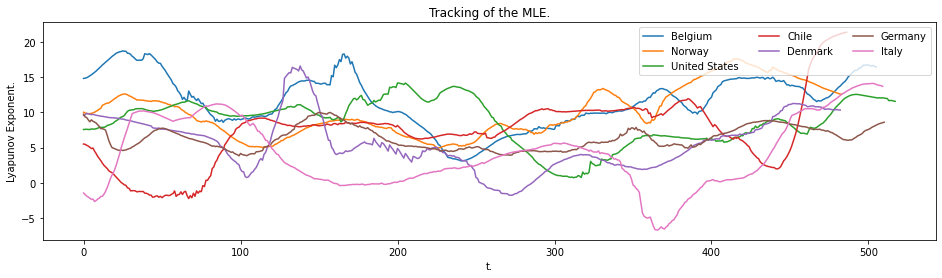

In [22]:
plt.figure(figsize=(16,4))
for k in range(7):
    plt.plot(Lyapse[k][:600])
plt.xlabel('t.')
plt.ylabel('Lyapunov Exponent.')
plt.title('Tracking of the MLE.')
plt.legend(Countries,loc='upper right',ncol=3)
plt.show()

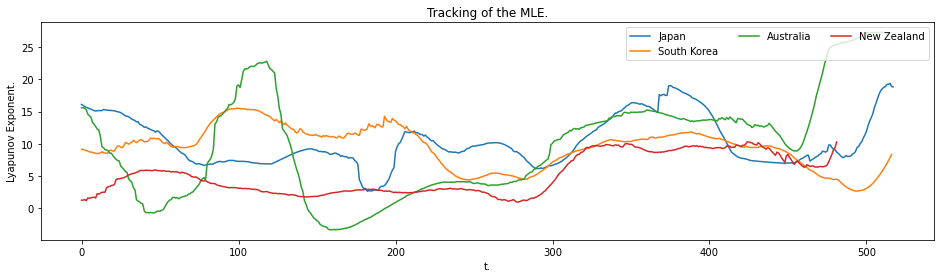

In [23]:
plt.figure(figsize=(16,4))
for k in range(7,N):
    plt.plot(Lyapse[k][:600])
plt.xlabel('t.')
plt.ylabel('Lyapunov Exponent.')
plt.title('Tracking of the MLE.')
plt.legend(Countries[7:],loc='upper right',ncol=3)
plt.show()

In [24]:
Countries=['Belgium', 'Norway', 'United States', 'Chile', 'Denmark', 'Germany', 'Italy', 'Japan', 'South Korea',
       'Australia','New Zealand']

In [26]:
DatesBelgium=Blegiumdata['date'].astype(str).values.tolist()
DatesNorway=Norwaydata['date'].astype(str).values.tolist()[1:]
DatesUS=USdata['date'].astype(str).values.tolist()[1:]
DatesChile=Chiledata['date'].astype(str).values.tolist()
DatesDenmark=Denmarkdata['date'].astype(str).values.tolist()[25:]
DatesCanada=Canadadata['date'].astype(str).values.tolist()
DatesCzechR=CzechRdata['date'].astype(str).values.tolist()
DatesNZ=NZdata['date'].astype(str).values.tolist()
DatesGermany=Germanydata['date'].astype(str).values.tolist()[3:]
DatesItalyts=Italydata['date'].astype(str).values.tolist()
DatesJapan=Japandata['date'].astype(str).values.tolist()[1:]
DatesSK=SKdata['date'].astype(str).values.tolist()[2:]
DatesAustralia=Australiadata['date'].astype(str).values.tolist()

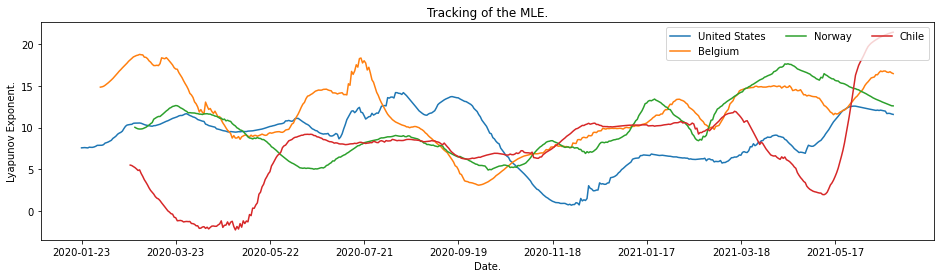

In [27]:
plt.figure(figsize=(16,4))
plt.plot(DatesUS[:len(Lyapse[2])],Lyapse[2])
plt.plot(DatesBelgium[:len(Lyapse[0])],Lyapse[0])
plt.plot(DatesNorway[:len(Lyapse[1])],Lyapse[1])
plt.plot(DatesChile[:len(Lyapse[3])],Lyapse[3])
plt.xlabel('Date.')
plt.ylabel('Lyapunov Exponent.')
plt.title('Tracking of the MLE.')
plt.legend(['United States','Belgium', 'Norway',  'Chile'],loc='upper right',ncol=3)
plt.xticks([0,60,120,180,240,300,360,420,480])
plt.show()

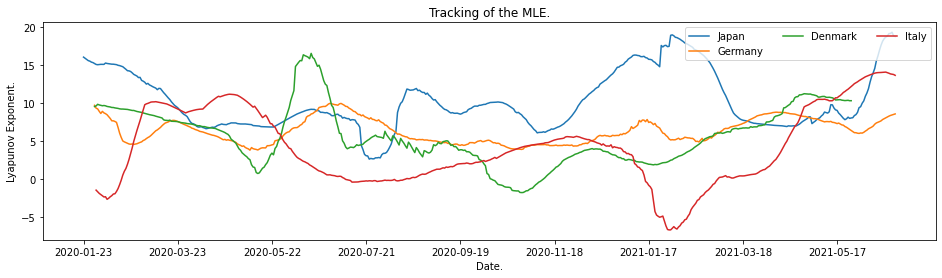

In [28]:
plt.figure(figsize=(16,4))
plt.plot(DatesJapan[:len(Lyapse[7])],Lyapse[7])
plt.plot(DatesGermany[:len(Lyapse[5])],Lyapse[5])
plt.plot(DatesGermany[:len(Lyapse[4])],Lyapse[4])
plt.plot(DatesItalyts[:len(Lyapse[6])],Lyapse[6])

plt.xlabel('Date.')
plt.ylabel('Lyapunov Exponent.')
plt.title('Tracking of the MLE.')
plt.legend(['Japan','Germany','Denmark','Italy'],loc='upper right',ncol=3)
plt.xticks([0,60,120,180,240,300,360,420,480])
plt.show()

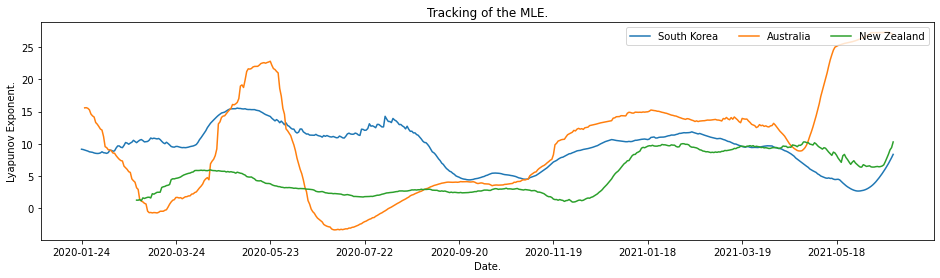

In [29]:
plt.figure(figsize=(16,4))
plt.plot(DatesSK[:len(Lyapse[8])],Lyapse[8])
plt.plot(DatesAustralia[:len(Lyapse[9])],Lyapse[9])
plt.plot(DatesNZ[:len(Lyapse[10])],Lyapse[10])
plt.xticks([0,60,120,180,240,300,360,420,480])
plt.xlabel('Date.')
plt.ylabel('Lyapunov Exponent.')
plt.title('Tracking of the MLE.')
plt.legend(['South Korea', 'Australia','New Zealand'],loc='upper right',ncol=3)
plt.show()

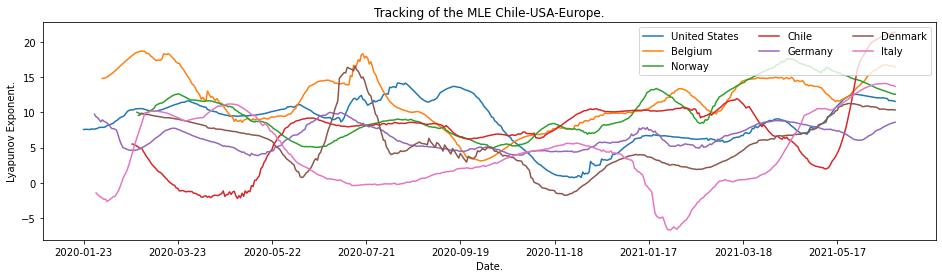

In [30]:
plt.figure(figsize=(16,4))
plt.plot(DatesUS[:len(Lyapse[2])],Lyapse[2])
plt.plot(DatesBelgium[:len(Lyapse[0])],Lyapse[0])
plt.plot(DatesNorway[:len(Lyapse[1])],Lyapse[1])
plt.plot(DatesChile[:len(Lyapse[3])],Lyapse[3])
plt.plot(DatesGermany[:len(Lyapse[5])],Lyapse[5])
plt.plot(DatesDenmark[:len(Lyapse[4])],Lyapse[4])
plt.plot(DatesItalyts[:len(Lyapse[6])],Lyapse[6])

plt.xlabel('Date.')
plt.ylabel('Lyapunov Exponent.')
plt.title('Tracking of the MLE Chile-USA-Europe.')
plt.legend(['United States','Belgium', 'Norway',  'Chile','Germany', 'Denmark', 'Italy'],loc='upper right',ncol=3)
plt.xticks([0,60,120,180,240,300,360,420,480])
plt.show()

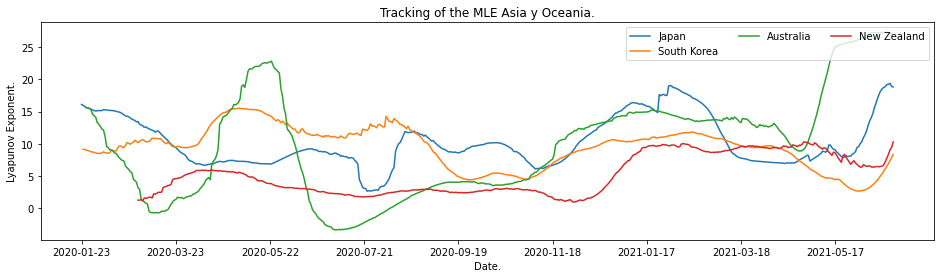

In [31]:
plt.figure(figsize=(16,4))
plt.plot(DatesJapan[:len(Lyapse[7])],Lyapse[7])
plt.plot(DatesSK[:len(Lyapse[8])],Lyapse[8])
plt.plot(DatesAustralia[:len(Lyapse[9])],Lyapse[9])
plt.plot(DatesNZ[:len(Lyapse[10])],Lyapse[10])
plt.xticks([0,60,120,180,240,300,360,420,480])
plt.xlabel('Date.')
plt.ylabel('Lyapunov Exponent.')
plt.title('Tracking of the MLE Asia y Oceania.')
plt.legend(['Japan','South Korea', 'Australia','New Zealand'],loc='upper right',ncol=3)
plt.show()

In [32]:
import numpy as np
Countries=['Belgium', 'Norway', 'United States', 'Chile', 'Denmark', 'Germany', 'Italy', 'Japan', 'South Korea',
       'Australia','New Zealand']
for j in range(len(Countries)):
    a = np.asarray([ Lyapse[j]])
    np.savetxt( Countries[j]+'.csv', a, delimiter=",")